# Install Library

In [ ]:
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.8 MB/s eta 0:00:00


# Import Library

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
import time
import os
import ast
import torch
import psutil
import platform
import re

from google.colab import drive
drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


# Check Specification

In [ ]:
# CPU info
print("🔹 CPU info:")
print("CPU count:", os.cpu_count())
print("Processor:", platform.processor())
!lscpu | grep 'Model name'

# RAM info
print("\n🔹 RAM info:")
ram_bytes = psutil.virtual_memory().total
print("Total RAM (GB):", round(ram_bytes / (1024**3), 2))

# Disk info
print("\n🔹 Disk info:")
disk = psutil.disk_usage('/')
print("Total Disk (GB):", round(disk.total / (1024**3), 2))
print("Used Disk (GB):", round(disk.used / (1024**3), 2))
print("Free Disk (GB):", round(disk.free / (1024**3), 2))

# GPU info
print("\n🔹 GPU info:")
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
!nvidia-smi


🔹 CPU info:
CPU count: 2
Processor: x86_64
Model name:                              Intel(R) Xeon(R) CPU @ 2.00GHz

🔹 RAM info:
Total RAM (GB): 12.67

🔹 Disk info:
Total Disk (GB): 112.64
Used Disk (GB): 38.11
Free Disk (GB): 74.51

🔹 GPU info:
CUDA available: True
CUDA device count: 1
Wed Nov 26 09:28:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                      

# Configuration

In [ ]:
project_path = "/content/drive/MyDrive/Colab Notebooks/soccer-player-tracking"
video_path = project_path+"/Dataset/highlight fifa world cup trim.mp4"

# Create output folder if not available yet
save_dir = project_path+"/Output"
dirs = ["Before Correction", "After Correction", "Original Data"]
for d in dirs:
    os.makedirs(os.path.join(save_dir, d, "Frames"), exist_ok=True)

# PLEASE SELECT mbc mode
mbc_mode = True # majority based correction (mbc) = True (active) / False (inactive)
if mbc_mode == True:
  mbc_active_dir = dirs[1]
else:
  mbc_active_dir = dirs[0]
print(f"Selected directory: {mbc_active_dir}")

# Automatically select device
selected_device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {'GPU' if selected_device==0 else 'CPU'}")

# Number of Initial Frames for Color's Reference
N_INIT_FRAMES = 40 # Default = 40
print("N_INIT_FRAMES: ", N_INIT_FRAMES)

# Save original frames from the video source
save_original_frames = False # Default = False

Selected directory: After Correction
Using device: GPU
N_INIT_FRAMES:  40


# Tracking Data Generation

In [ ]:
# === 1. Load YOLO model and video ===
model = YOLO("yolov8l.pt")
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

# === 2. Take color reference from the first N frames ===
ref_vectors = []
frame_counter = 0
valid_frames = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
track_results = model.track(source=video_path, tracker="bytetrack.yaml", stream=True, verbose=False, device=selected_device)
print("🔍 Searching for jersey color reference...")

for frame_result in track_results:
    if valid_frames >= N_INIT_FRAMES:
        break  # Stop if enough valid frames have been collected

    frame = frame_result.orig_img.copy()
    current_time_sec = frame_counter / fps
    h_t = int(current_time_sec // 3600)
    m_t = int((current_time_sec % 3600) // 60)
    s_t = int(current_time_sec % 60)
    print(f"[{h_t:02}:{m_t:02}:{s_t:02}] Frame {frame_counter}, valid_frames={valid_frames}")

    # Create a pitch mask from the green color
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask_pitch = cv2.inRange(hsv, (36, 50, 50), (85, 255, 255))
    contours, _ = cv2.findContours(mask_pitch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pitch_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    if contours:
        cv2.drawContours(pitch_mask, [max(contours, key=cv2.contourArea)], -1, 255, -1)

    boxes = frame_result.boxes
    if boxes is None or boxes.id is None:
        frame_counter += 1
        continue # Skip the frame if there are not enough detections

    appended = False
    for box, cls in zip(boxes.xyxy.cpu().numpy(), boxes.cls.cpu().numpy()):
        # Get bounding box coordinates: (x1, y1) = top-left corner, (x2, y2) = bottom-right corner
        x1, y1, x2, y2 = map(int, box)

        # Only process objects with class = 0 (person), skip other objects (ball, goal, etc.)
        if int(cls) != 0:
            continue
        # Ensure the bounding box size is reasonable (not too small/large)
        # < 10 px is considered noise, > 100/150 px likely a false detection (too close/zoomed in)
        if (x2 - x1) < 10 or (y2 - y1) < 10 or (x2 - x1) > 100 or (y2 - y1) > 150:
            continue
        # Calculate the center coordinates of the bounding box
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        # Check if the player's center is within the pitch area (field mask)
        if cy >= pitch_mask.shape[0] or cx >= pitch_mask.shape[1]:
            continue
        # Check if the player's center is actually inside the field area (green = 255, not green = 0)
        if pitch_mask[cy, cx] != 255:
            continue
        # Crop the player's area based on the bounding box
        crop = frame[y1:y2, x1:x2]
        # Skip if the crop is empty (could be due to wrong coordinates or out of range)
        if crop.size == 0:
            continue

        hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, (36, 50, 50), (85, 255, 255))  # green removal
        filtered = cv2.bitwise_and(hsv, hsv, mask=cv2.bitwise_not(mask))
        hch, sch, vch = cv2.split(filtered)
        valid = (sch > 1) & (vch > 1)
        if np.any(valid):
            pixels = np.stack([hch[valid], sch[valid], vch[valid]], axis=1)
            if len(pixels) >= 10:
                kmeans = KMeans(n_clusters=3, n_init=5).fit(pixels)
                labels, counts = np.unique(kmeans.labels_, return_counts=True)
                dominant_cluster_idx = labels[np.argmax(counts)]
                ref_vectors.append(kmeans.cluster_centers_[dominant_cluster_idx])
                appended = True

    if appended:
        valid_frames += 1  # Add only if the append was successful
        # # Konversi BGR (OpenCV) ke RGB (Matplotlib)
        # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # plt.figure(figsize=(10, 6))
        # plt.imshow(frame_rgb)
        # plt.title(f"Frame-{frame_counter}")
        # plt.axis('off')
        # plt.show()
    frame_counter += 1

# Cluster into 2 teams
if len(ref_vectors) < 5:
    print("❌ Gagal: warna referensi tidak cukup!")
    exit()
kmeans_ref = KMeans(n_clusters=2, n_init=5)
labels = kmeans_ref.fit_predict(ref_vectors)
ref_A, ref_B = kmeans_ref.cluster_centers_
print(f"✅ Jersey color A: {ref_A}, B: {ref_B}")

# === 3. First pass tracker (to find referee outliers) ===
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

track_results = model.track(source=video_path, tracker="bytetrack.yaml", stream=True, verbose=False, device=selected_device)
frame_counter = 0
count = 0

# === 4. Process frames after tracking ===
start_time = time.time()
session_id = 0
prev_ids = set()
track_data_dict = {}
for frame_result in track_results:
    frame = frame_result.orig_img.copy()
    current_time_sec = frame_counter / fps
    h_t = int(current_time_sec // 3600)
    m_t = int((current_time_sec % 3600) // 60)
    s_t = int(current_time_sec % 60)
    print(f"[{h_t:02}:{m_t:02}:{s_t:02}] Frame {frame_counter}")

    # Save the original frame to folder with names like 0.jpg, 1.jpg, etc.
    if save_original_frames == True:
      save_path = os.path.join(save_dir, dirs[2], "Frames", f"Frame {frame_counter}.jpg")
      cv2.imwrite(save_path, frame)

    # Create a pitch mask from the green color
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask_pitch = cv2.inRange(hsv, (36, 50, 50), (85, 255, 255))
    contours, _ = cv2.findContours(mask_pitch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pitch_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    if contours:
        cv2.drawContours(pitch_mask, [max(contours, key=cv2.contourArea)], -1, 255, -1)

    boxes = frame_result.boxes
    if boxes is None or boxes.id is None:
        # out.write(frame)
        frame_counter += 1
        continue

    for box, track_id, cls in zip(boxes.xyxy.cpu().numpy(), boxes.id.cpu().numpy(), boxes.cls.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)
        track_id = int(track_id)

        # Skip frame
        if int(cls) != 0:
            continue  # Skip objects other than person
        # Ensure the crop is valid
        if (x2 - x1) < 10 or (y2 - y1) < 10 or (x2 - x1) > 100 or (y2 - y1) > 150:
            continue
        # Calculate the centroid
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        # Ensure the centroid is within the pitch
        if cy >= pitch_mask.shape[0] or cx >= pitch_mask.shape[1]:
            continue
        if pitch_mask[cy, cx] != 255:
            continue
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, (36, 50, 50), (85, 255, 255))
        filtered = cv2.bitwise_and(hsv, hsv, mask=cv2.bitwise_not(mask))
        hch, sch, vch = cv2.split(filtered)
        valid = (sch > 1) & (vch > 1)

        if np.any(valid):
            pixels = np.stack([hch[valid], sch[valid], vch[valid]], axis=1)
            if len(pixels) >= 10:
                kmeans = KMeans(n_clusters=3, n_init=5).fit(pixels)
                labels, counts = np.unique(kmeans.labels_, return_counts=True)
                dominant_cluster_idx = labels[np.argmax(counts)]
                dominant_hsv_color = kmeans.cluster_centers_[dominant_cluster_idx]

                # Calculate distance to the reference
                dist_A = np.linalg.norm(dominant_hsv_color - ref_A)
                dist_B = np.linalg.norm(dominant_hsv_color - ref_B)

                # Save to tracking data
                track_data_dict[(frame_counter, track_id)] = {
                    'x1': x1,
                    'y1': y1,
                    'x2': x2,
                    'y2': y2,
                    'dominant_hsv_color': dominant_hsv_color,
                    'dist_A': dist_A,
                    'dist_B': dist_B,
                }

    # if frame_counter > 1:
    #     break
    frame_counter += 1

### Create a DataFrame from a dictionary
df = DataFrame.from_dict(track_data_dict, orient='index')
# Convert the index (still a tuple) into a new column
df[['FrameID', 'TrackID']] = DataFrame(df.index.tolist(), index=df.index)
# Reset the index and drop the old index
df.reset_index(drop=True, inplace=True)

### Determine session ID based on TrackID overlap between frames
df = df.sort_values(by=["FrameID", "TrackID"]).reset_index(drop=True)
session_id = 0
prev_ids = set()
session_ids = []
for frame_id, group in df.groupby("FrameID"):
    curr_ids = set(group["TrackID"])
    overlap_ratio = len(prev_ids & curr_ids) / max(len(prev_ids | curr_ids), 1)

    if frame_id == 0:
        session_id = 0
    elif overlap_ratio < 0.3:
        session_id += 1

    # Add session_id to each row in the same group/frame
    session_ids.extend([session_id] * len(group))
    prev_ids = curr_ids
df["session_id"] = session_ids

### Get min_dist for each TrackID
df["min_dist"] = df[["dist_A", "dist_B"]].min(axis=1)

### Calculate the 95th percentile threshold of min_dist per FrameID
frame_thresholds = df.groupby("FrameID")["min_dist"].quantile(0.95).rename("threshold")
df = df.merge(frame_thresholds, on="FrameID")

### Directly assign 'X' if min_dist > threshold, otherwise "A" or "B"
df["team_assignment"] = np.where(
    df["min_dist"] > df["threshold"],
    "X",
    np.where(df["dist_A"] < df["dist_B"], "A", "B")
)

### Take the majority team_assignment per TrackID
if mbc_mode == True:
  majority_team = (
      df.groupby("TrackID")["team_assignment"]
      .agg(lambda x: x.value_counts().idxmax())
  )
  df["majority_team"] = df["TrackID"].map(majority_team)
  df["team_assignment"] = df["majority_team"]
  df.drop(columns=["majority_team"], inplace=True)

### Add a team color column based on team_assignment (BGR)
df["team_box_color"] = df["team_assignment"].replace({
    "A": "(255, 0, 0)",
    "B": "(0, 255, 0)",
    "X": "(0, 0, 255)"
})

### Calculate the number of players in team A and B per FrameID
jumlah_per_frame = (
    df[df["team_assignment"].isin(["A", "B"])]
    .groupby(["FrameID", "team_assignment"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=["A", "B"], fill_value=0)  # <== pastikan kolom A dan B ada
    .rename(columns={"A": "total_team_A", "B": "total_team_B"})
)
df = df.merge(jumlah_per_frame, how="left", on="FrameID")
df["total_team_A"] = df["total_team_A"].fillna(0).astype(int)
df["total_team_B"] = df["total_team_B"].fillna(0).astype(int)

### Calculate center x and y and their average per FrameID
df["center_x"] = (df["x1"] + df["x2"]) // 2
df["center_y"] = (df["y1"] + df["y2"]) // 2
frame_stats = (
    df.groupby(["FrameID", "team_assignment"])
      .agg(avg_x=("center_x", "mean"), avg_y=("center_y", "mean"))
      .reset_index()
)
df = df.merge(frame_stats, on=["FrameID", "team_assignment"], how="left")
df = df.round(2)

### Calculate processing FPS
end_time = time.time()
elapsed_time = end_time - start_time
processing_fps = frame_counter / elapsed_time
print("Processing FPS:", processing_fps)

### Save to csv
print("📂 Saving tracking results to data_tracking.csv...")
df.to_csv(f"{save_dir}/{mbc_active_dir}/data_tracking.csv", index=False, sep=";")

# Display DataFrame
print("\n📊 Tracking results DataFrame:")
display(df)

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 95ms
Prepared 1 package in 23ms
Installed 1 package in 1ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

🔍 Searching for jersey color reference...
[00:00:00] Frame 0, valid_frames=0
[00:00:00] Frame 1, valid_frames=1
[00:00:00] Frame 2, valid_frames=2
[00:00:00] Frame 3, valid_frames=3
[00:00:00] Frame 4, valid_frames=4
[00:00:00] Frame 5, valid_frames=5
[00:00:00] Frame 6, valid_frames=6
[00:00:00] Frame 7, valid_frames=7
[00:00:00] Frame 8, valid_frames=8
[00:00:00] Frame 9, valid_frames=9
[00:00:00] Frame 10, valid_frames=10
[00:00:00] Frame 11, valid_frames=11
[00:00:00] Frame 12, valid_frames=12
[00:00:00] Frame 13, valid_frames=13
[00:00:00] Frame 14, valid_frames=14
[00:00:00] Frame 15, valid_frames=15
[00:00:00] Frame 16, valid_fra

,x1,y1,x2,y2,dominant_hsv_color,dist_A,dist_B,FrameID,TrackID,session_id,min_dist,threshold,team_assignment,team_box_color,total_team_A,total_team_B,center_x,center_y,avg_x,avg_y
0,259,574,309,687,"[105.54773869346735, 59.057286432160886, 234.8...",125.17,10.83,0,1,0,10.83,95.72,B,"(0, 255, 0)",8,9,284,630,910.22,551.33
1,92,444,153,548,"[62.226648351648294, 55.743131868132274, 129.2...",73.92,111.51,0,3,0,73.92,95.72,A,"(255, 0, 0)",8,9,122,496,1121.62,528.50
2,1719,493,1761,606,"[104.15710723192029, 79.0847880299255, 140.900...",41.61,95.54,0,4,0,41.61,95.72,A,"(255, 0, 0)",8,9,1740,549,1121.62,528.50
3,495,447,536,555,"[106.2437971952537, 45.04854368932052, 231.511...",129.45,3.75,0,5,0,3.75,95.72,B,"(0, 255, 0)",8,9,515,501,910.22,551.33
4,855,466,906,550,"[98.22779043280181, 37.39407744874728, 233.728...",135.70,14.16,0,6,0,14.16,95.72,B,"(0, 255, 0)",8,9,880,508,910.22,551.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,839,573,900,668,"[87.6222222222222, 75.80707070707035, 120.9353...",44.21,115.33,687,726,1,44.21,100.38,A,"(255, 0, 0)",2,5,869,620,789.50,668.00
4080,1658,433,1717,545,"[100.49891304347861, 37.4271739130434, 227.411...",130.56,13.41,687,728,1,13.41,100.38,B,"(0, 255, 0)",2,5,1687,489,1257.80,604.40
4081,670,649,751,784,"[109.97876106194676, 218.66106194690244, 111.2...",102.59,208.14,687,730,1,102.59,100.38,A,"(255, 0, 0)",2,5,710,716,789.50,668.00
4082,1694,612,1758,741,"[99.20182370820696, 39.607294832826824, 230.88...",132.07,11.63,687,765,1,11.63,100.38,B,"(0, 255, 0)",2,5,1726,676,1257.80,604.40


# Rendering Annotated Frames Using Tracking Data

In [ ]:
# === 1. Load YOLO model and video ===
model = YOLO("yolov8l.pt")
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter(f"{save_dir}/{mbc_active_dir}/soccer_tracking.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

# === 2. Read tracking data ===
df = read_csv(f"{save_dir}/{mbc_active_dir}/data_tracking.csv", sep=";")

# === 3. Process frames after tracking ===
print("🔍 Processing frames after tracking...")
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
track_results = model.track(source=video_path, tracker="bytetrack.yaml", stream=True, verbose=False, device=selected_device)
frame_counter = 0
for frame_result in track_results:
    frame = frame_result.orig_img.copy()
    current_time_sec = frame_counter / fps
    h_t = int(current_time_sec // 3600)
    m_t = int((current_time_sec % 3600) // 60)
    s_t = int(current_time_sec % 60)
    print(f"[{h_t:02}:{m_t:02}:{s_t:02}] Frame {frame_counter}")

    df_fid = df[df["FrameID"] == frame_counter]
    # print(f"Number of TrackIDs in frame {frame_counter}: {len(df_fid)}")
    # display(df_fid)

    # If there are no TrackIDs in this frame, skip but still save the frame
    if df_fid.empty:
        # Convert BGR (OpenCV) to RGB (Matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(frame_rgb)
        plt.title(f"Frame-{frame_counter}")
        plt.axis('off')
        # plt.show()
        plt.savefig(f"{save_dir}/{mbc_active_dir}/Frames/frame_{frame_counter}_skipped.png", bbox_inches='tight')
        plt.close()

        print(f"[Frame {frame_counter}] ⏩ No FrameID found.")
        out.write(frame)
        frame_counter += 1
        continue

    # # If there are no TrackIDs in this frame, skip and do not save the frame
    # if df_fid.empty:
    #     print(f"[Frame {frame_counter}] ⏩ No TrackID, skipping this frame.")
    #     frame_counter += 1
    #     continue

    for index, row in df_fid.iterrows():
        fid = row["FrameID"]
        track_id = row["TrackID"]
        x1, y1, x2, y2 = row["x1"], row["y1"], row["x2"], row["y2"]
        team_assignment = row["team_assignment"]
        team_box_color = eval(row["team_box_color"])
        # print(f"Frame {fid}, Track ID {track_id}: Team {team_assignment}, Box Color {team_box_color}")

        cv2.rectangle(frame, (x1, y1), (x2, y2), team_box_color, 2)
        cv2.putText(frame, f"{team_assignment} ID:{track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, team_box_color, 2)

    # Convert BGR (OpenCV) to RGB (Matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame-{frame_counter}")
    plt.axis('off')
    # plt.show()
    plt.savefig(f"{save_dir}/{mbc_active_dir}/Frames/frame_{frame_counter}.png", bbox_inches='tight')
    plt.close()

    # if frame_counter > 10:
    #     break

    frame_counter += 1
    out.write(frame)

print("🎉 Process completed.")
cap.release()
out.release()
cv2.destroyAllWindows()

🔍 Processing frames after tracking...
[00:00:00] Frame 0
[00:00:00] Frame 1
[00:00:00] Frame 2
[00:00:00] Frame 3
[00:00:00] Frame 4
[00:00:00] Frame 5
[00:00:00] Frame 6
[00:00:00] Frame 7
[00:00:00] Frame 8
[00:00:00] Frame 9
[00:00:00] Frame 10
[00:00:00] Frame 11
[00:00:00] Frame 12
[00:00:00] Frame 13
[00:00:00] Frame 14
[00:00:00] Frame 15
[00:00:00] Frame 16
[00:00:00] Frame 17
[00:00:00] Frame 18
[00:00:00] Frame 19
[00:00:00] Frame 20
[00:00:00] Frame 21
[00:00:00] Frame 22
[00:00:00] Frame 23
[00:00:00] Frame 24
[00:00:00] Frame 25
[00:00:00] Frame 26
[00:00:00] Frame 27
[00:00:00] Frame 28
[00:00:00] Frame 29
[00:00:00] Frame 30
[00:00:01] Frame 31
[00:00:01] Frame 32
[00:00:01] Frame 33
[00:00:01] Frame 34
[00:00:01] Frame 35
[00:00:01] Frame 36
[00:00:01] Frame 37
[00:00:01] Frame 38
[00:00:01] Frame 39
[00:00:01] Frame 40
[00:00:01] Frame 41
[00:00:01] Frame 42
[00:00:01] Frame 43
[00:00:01] Frame 44
[00:00:01] Frame 45
[00:00:01] Frame 46
[00:00:01] Frame 47
[00:00:01] F

# Visualization

## Effectiveness of Preprocessing Strategy

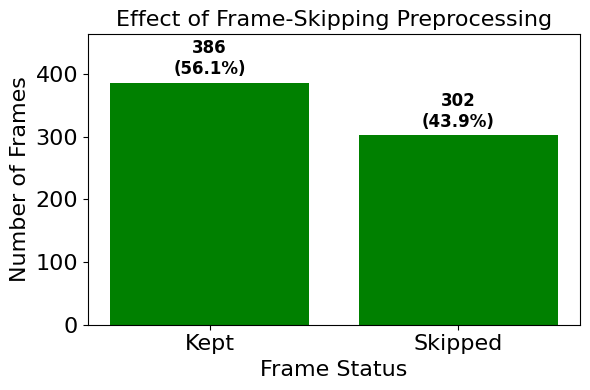

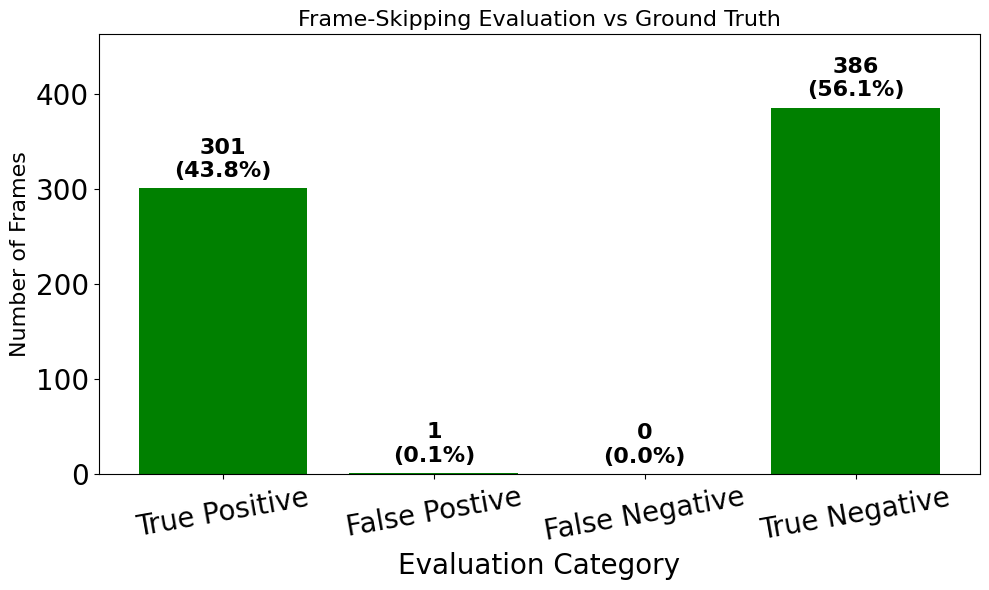

Saving /content/drive/MyDrive/Colab Notebooks/soccer-player-tracking/Output/After Correction/preprocessing_results.csv...


,filename,skipped_frame,frame_number,gt_skipped_frame
0,frame_0.png,0,0,0
1,frame_1.png,0,1,0
2,frame_2.png,0,2,0
3,frame_3.png,0,3,0
4,frame_4.png,0,4,0
...,...,...,...,...
683,frame_683.png,0,683,0
684,frame_684.png,0,684,0
685,frame_685.png,0,685,0
686,frame_686.png,0,686,0


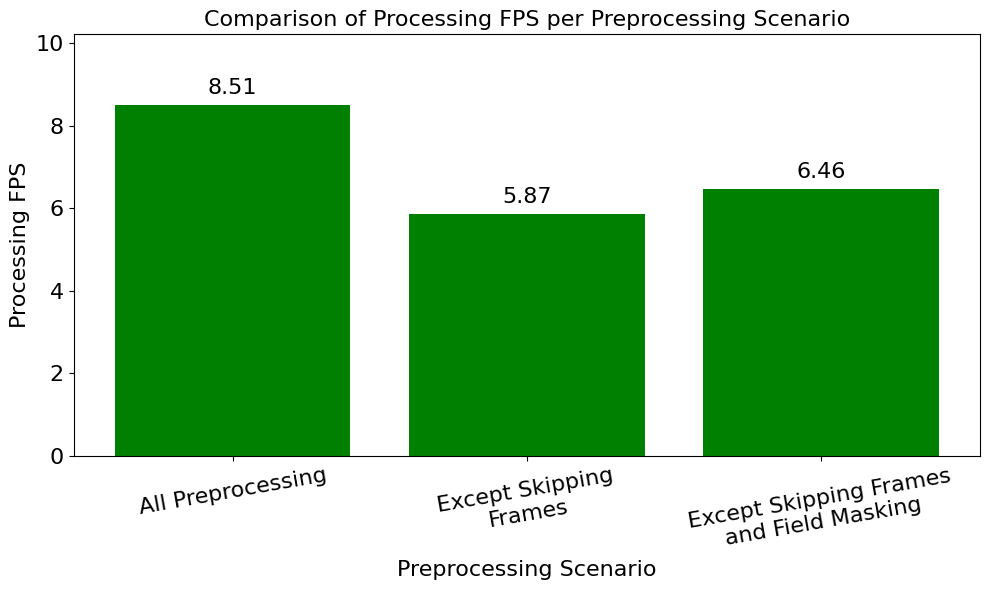

In [ ]:
# === PATH TO FRAME FILES ===
folder_path = f"{save_dir}/{mbc_active_dir}/Frames"

# === 1. Read all PNG files in the folder ===
file_list = [f for f in os.listdir(folder_path) if f.endswith(".png")]

# === 2. Create DataFrame ===
df_files = DataFrame({"filename": file_list})

# === 3. Add skipped_frame column ===
df_files["skipped_frame"] = df_files["filename"].apply(lambda x: 1 if "skipped" in x else 0)

# === 4. Add frame_number column extracted from filename ===
def extract_frame_number(fname):
    match = re.search(r'frame_(\d+)', fname)
    return int(match.group(1)) if match else None
df_files["frame_number"] = df_files["filename"].apply(extract_frame_number)

# === 5. Add GT skipped column (manual check: frame_160 to frame_460) ===
df_files["gt_skipped_frame"] = df_files["frame_number"].apply(lambda x: 1 if 160 <= x <= 460 else 0)

# === 6. Visualize Kept vs Skipped (single color) ===
total_frames = len(df_files)
skipped_frames = df_files["skipped_frame"].sum()
kept_frames = total_frames - skipped_frames
plt.figure(figsize=(6,4))
counts = [kept_frames, skipped_frames]
labels = ["Kept", "Skipped"]
bars = plt.bar(labels, counts, color="green")  # All bars green

plt.ylabel("Number of Frames", fontsize=16)
plt.xlabel("Frame Status", fontsize=16)
plt.title("Effect of Frame-Skipping Preprocessing", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(0, max(counts)*1.2)

for bar, count in zip(bars, counts):
    percent = count / total_frames * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.02,
             f"{count}\n({percent:.1f}%)", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# === 7. Full Evaluation Visualization (single color) ===
TP = ((df_files["skipped_frame"]==1) & (df_files["gt_skipped_frame"]==1)).sum()
FN = ((df_files["skipped_frame"]==0) & (df_files["gt_skipped_frame"]==1)).sum()
TN = ((df_files["skipped_frame"]==0) & (df_files["gt_skipped_frame"]==0)).sum()
FP = ((df_files["skipped_frame"]==1) & (df_files["gt_skipped_frame"]==0)).sum()

counts2 = [TP, FP, FN, TN]
labels2 = ["True Positive", "False Postive", "False Negative", "True Negative"]

plt.figure(figsize=(10,6))
bars2 = plt.bar(labels2, counts2, color="green")  # All bars green

plt.ylabel("Number of Frames", fontsize=16)
plt.xlabel("Evaluation Category", fontsize=20)
plt.title("Frame-Skipping Evaluation vs Ground Truth", fontsize=16)

plt.xticks(fontsize=20, rotation=10)
plt.yticks(fontsize=20)

plt.ylim(0, max(counts2)*1.2)

for bar, count in zip(bars2, counts2):
    percent = count / total_frames * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts2)*0.02,
             f"{count}\n({percent:.1f}%)", ha='center', va='bottom', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# === 8. Save DataFrame ===
df_files.to_csv(f"{save_dir}/{mbc_active_dir}/preprocessing_results.csv", index=False)
print("Saving "+f"{save_dir}/{mbc_active_dir}/preprocessing_results.csv...")
display(df_files)

# === 9. Effectiveness ===
scenarios = [
    "All Preprocessing",
    "Except Skipping\nFrames",
    "Except Skipping Frames\nand Field Masking"
]
fps_values = [8.513431486992024, 5.872656729638665, 6.456019202224159]

plt.figure(figsize=(10,6))
bars = plt.bar(scenarios, fps_values, color="green")  # All bars green
plt.xlabel("Preprocessing Scenario", fontsize=16)
plt.ylabel("Processing FPS", fontsize=16)
plt.title("Comparison of Processing FPS per Preprocessing Scenario", fontsize=16)
plt.ylim(0, max(fps_values)*1.2)

plt.xticks(fontsize=16, rotation=10)
plt.yticks(fontsize=16)

for bar, fps in zip(bars, fps_values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max(fps_values)*0.02,
        f"{fps:.2f}",
        ha='center',
        va='bottom',
        fontsize=16
    )
plt.tight_layout()
plt.show()


## End-to-End Pipeline for Player Detection and Tracking

In [ ]:
# === 1. Load dataframe ===
df = read_csv(
    f"{save_dir}/{mbc_active_dir}/preprocessing_results_with_gt.csv", # preprocessing reslts with ground truth (gt)
    delimiter=';'
)

# === 2. Compute aggregate per session ===
agg = df.groupby("session_id").agg({
    "team_A_no_correction": "sum",
    "team_B_no_correction": "sum",
    "team_X_no_correction": "sum",
    "team_A_correction": "sum",
    "team_B_correction": "sum",
    "team_X_correction": "sum",
    "filename": "count"  # number of frames per session
}).rename(columns={"filename": "total_frames"}).reset_index()

# === 3. Add total_no_correction and total_correction ===
agg["total_no_correction"] = agg["team_A_no_correction"] + agg["team_B_no_correction"] + agg["team_X_no_correction"]
agg["total_correction"] = agg["team_A_correction"] + agg["team_B_correction"] + agg["team_X_correction"]
# display(agg)

# === 4. Calculate correct percentage per team ===
for team in ["A", "B", "X"]:
    agg[f"{team}_no_correction_%"] = (agg[f"team_{team}_no_correction"] / agg["total_frames"] * 100).round(2)
    agg[f"{team}_correction_%"] = (agg[f"team_{team}_correction"] / agg["total_frames"] * 100).round(2)
    agg[f"{team}_improvement_%"] = (agg[f"{team}_correction_%"] - agg[f"{team}_no_correction_%"]).round(2)

display(agg)

# === 5. Calculate overall total (ALL sessions) ===
total_frames = len(df)
total = pd.DataFrame({
    "session_id": ["ALL"],
    "team_A_no_correction": [df["team_A_no_correction"].sum()],
    "team_B_no_correction": [df["team_B_no_correction"].sum()],
    "team_X_no_correction": [df["team_X_no_correction"].sum()],
    "team_A_correction": [df["team_A_correction"].sum()],
    "team_B_correction": [df["team_B_correction"].sum()],
    "team_X_correction": [df["team_X_correction"].sum()],
    "total_frames": [total_frames]
})

# Add total_no_correction and total_correction
total["total_no_correction"] = total["team_A_no_correction"] + total["team_B_no_correction"] + total["team_X_no_correction"]
total["total_correction"] = total["team_A_correction"] + total["team_B_correction"] + total["team_X_correction"]

for team in ["A", "B", "X"]:
    total[f"{team}_no_correction_%"] = (total[f"team_{team}_no_correction"] / total_frames * 100).round(2)
    total[f"{team}_correction_%"] = (total[f"team_{team}_correction"] / total_frames * 100).round(2)
    total[f"{team}_improvement_%"] = (total[f"{team}_correction_%"] - total[f"{team}_no_correction_%"]).round(2)

display(total)

# === 6. Combine total with per session ===
final_table = pd.concat([agg, total], ignore_index=True)

# === 7. Display final table ===
from IPython.display import display
print("=== Summary Per Session + Total (Correct Classification Percentage) ===")
display(final_table)


,session_id,team_A_no_correction,team_B_no_correction,team_X_no_correction,team_A_correction,team_B_correction,team_X_correction,total_frames,total_no_correction,total_correction,A_no_correction_%,A_correction_%,A_improvement_%,B_no_correction_%,B_correction_%,B_improvement_%,X_no_correction_%,X_correction_%,X_improvement_%
0,0,143,149,121,160,159,160,160,413,479,89.38,100.0,10.62,93.12,99.38,6.26,75.62,100.00,24.38
1,1,124,203,101,226,226,178,226,428,630,54.87,100.0,45.13,89.82,100.00,10.18,44.69,78.76,34.07


,session_id,team_A_no_correction,team_B_no_correction,team_X_no_correction,team_A_correction,team_B_correction,team_X_correction,total_frames,total_no_correction,total_correction,A_no_correction_%,A_correction_%,A_improvement_%,B_no_correction_%,B_correction_%,B_improvement_%,X_no_correction_%,X_correction_%,X_improvement_%
0,ALL,267,352,222,386,385,338,386,841,1109,69.17,100.0,30.83,91.19,99.74,8.55,57.51,87.56,30.05


=== Summary Per Session + Total (Correct Classification Percentage) ===


,session_id,team_A_no_correction,team_B_no_correction,team_X_no_correction,team_A_correction,team_B_correction,team_X_correction,total_frames,total_no_correction,total_correction,A_no_correction_%,A_correction_%,A_improvement_%,B_no_correction_%,B_correction_%,B_improvement_%,X_no_correction_%,X_correction_%,X_improvement_%
0,0,143,149,121,160,159,160,160,413,479,89.38,100.0,10.62,93.12,99.38,6.26,75.62,100.00,24.38
1,1,124,203,101,226,226,178,226,428,630,54.87,100.0,45.13,89.82,100.00,10.18,44.69,78.76,34.07
2,ALL,267,352,222,386,385,338,386,841,1109,69.17,100.0,30.83,91.19,99.74,8.55,57.51,87.56,30.05


## Interpretable Statistics

Processing session 0...


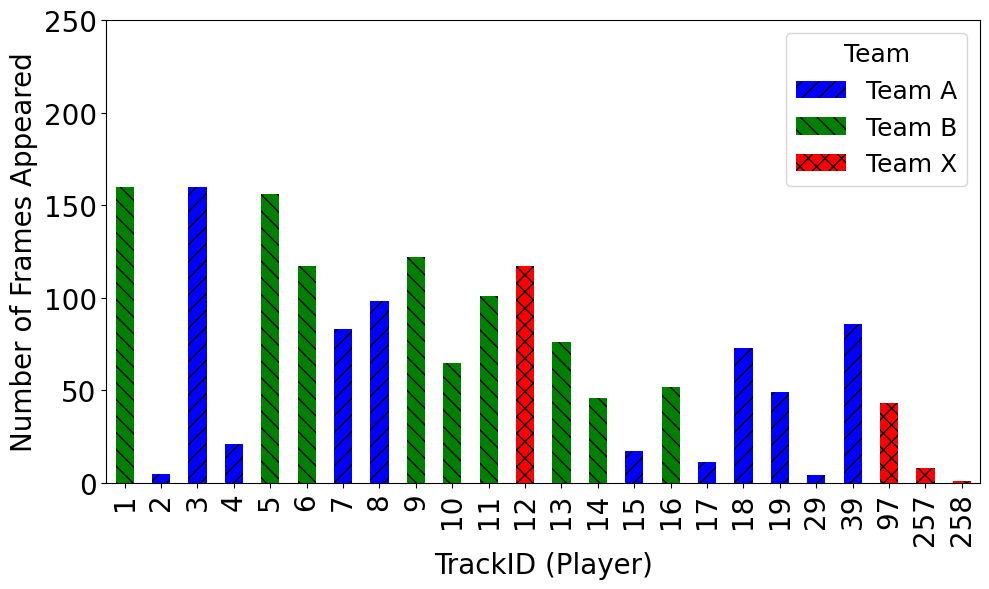

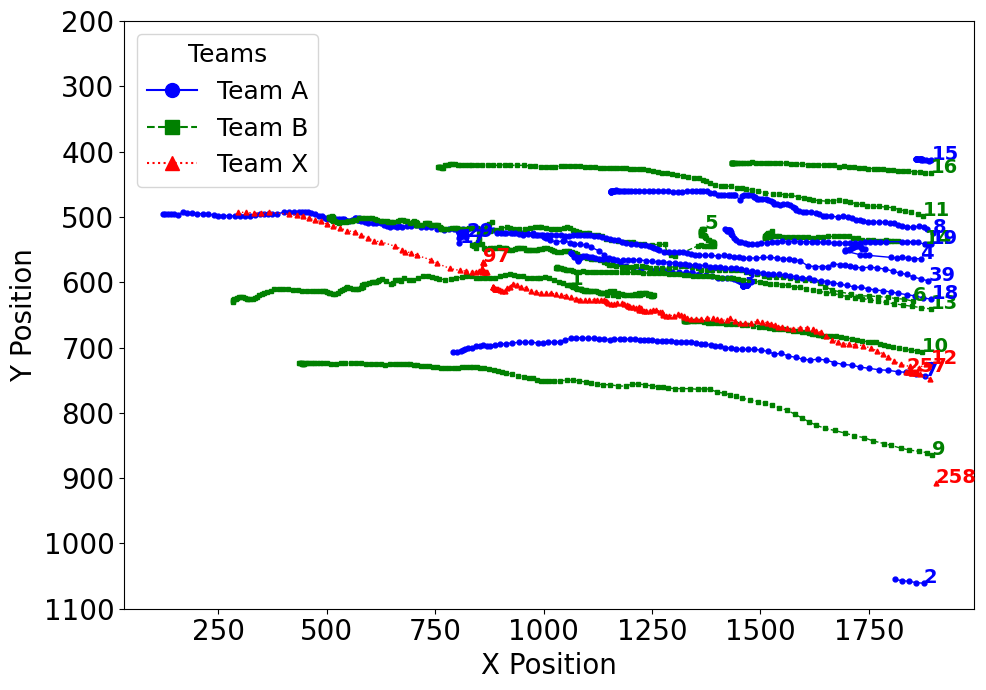

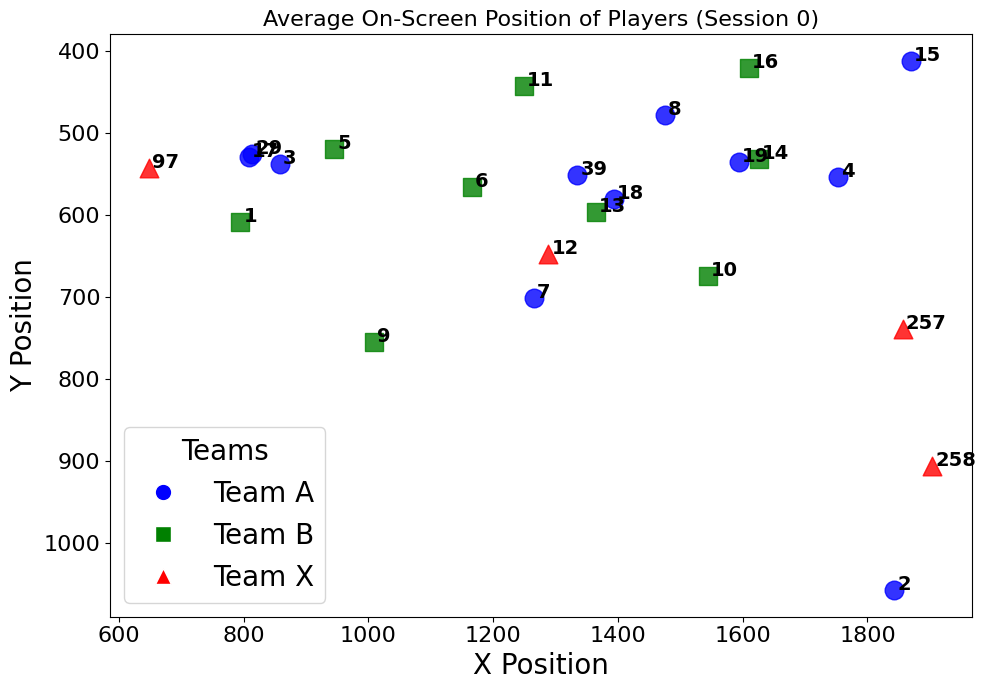

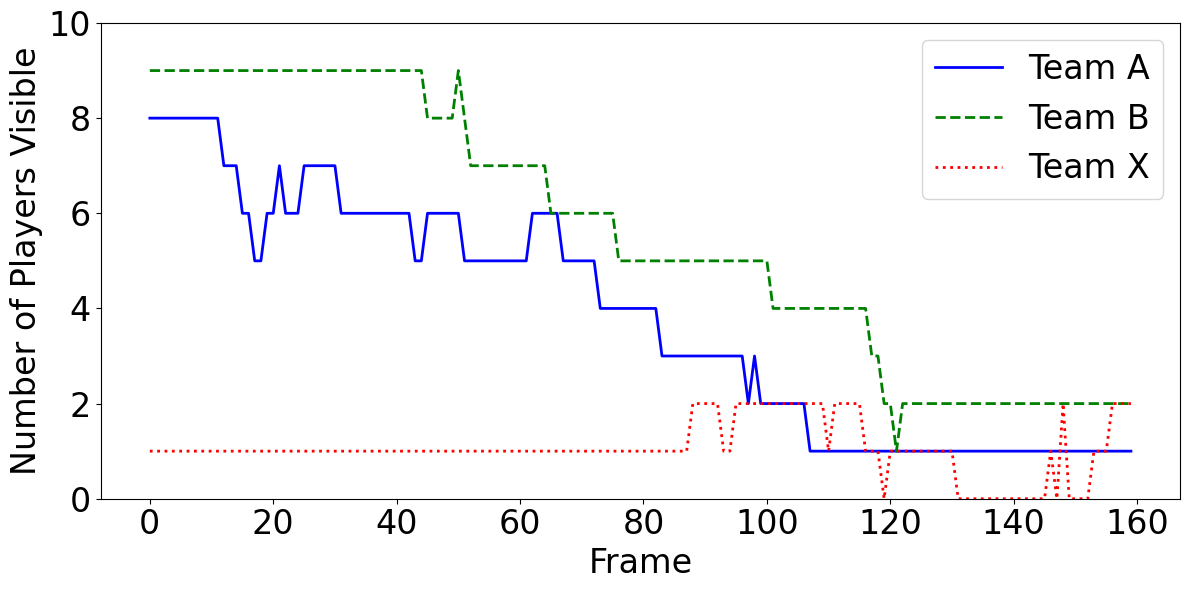

Processing session 1...


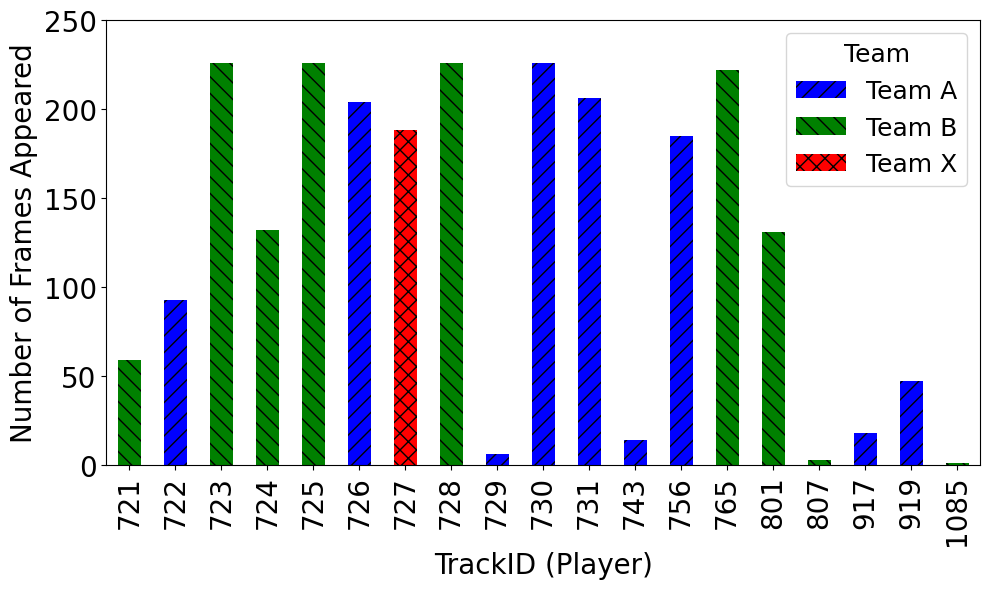

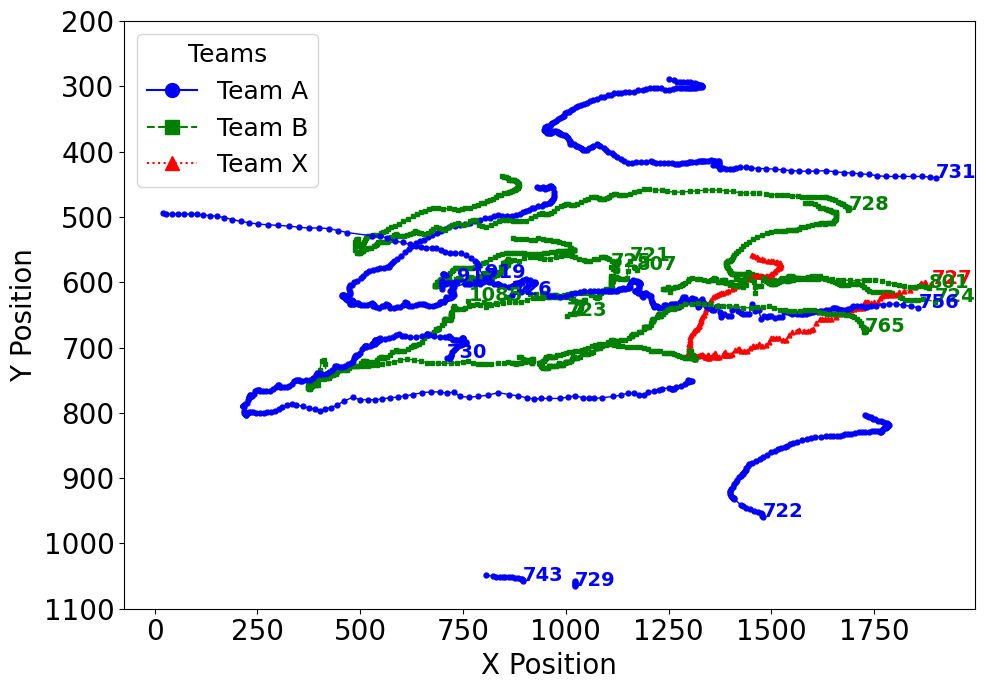

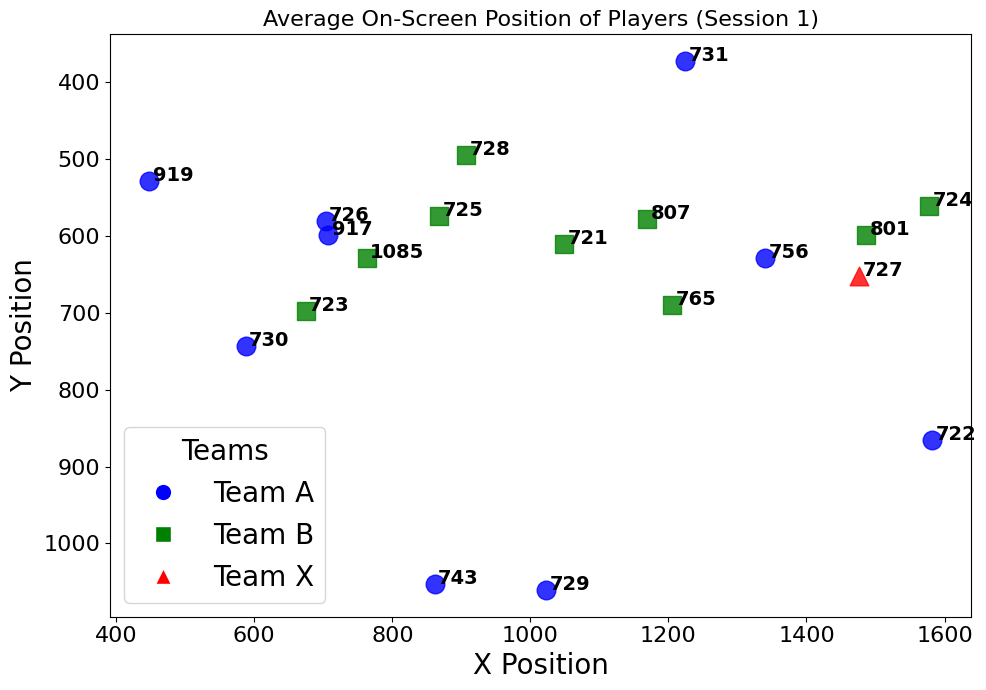

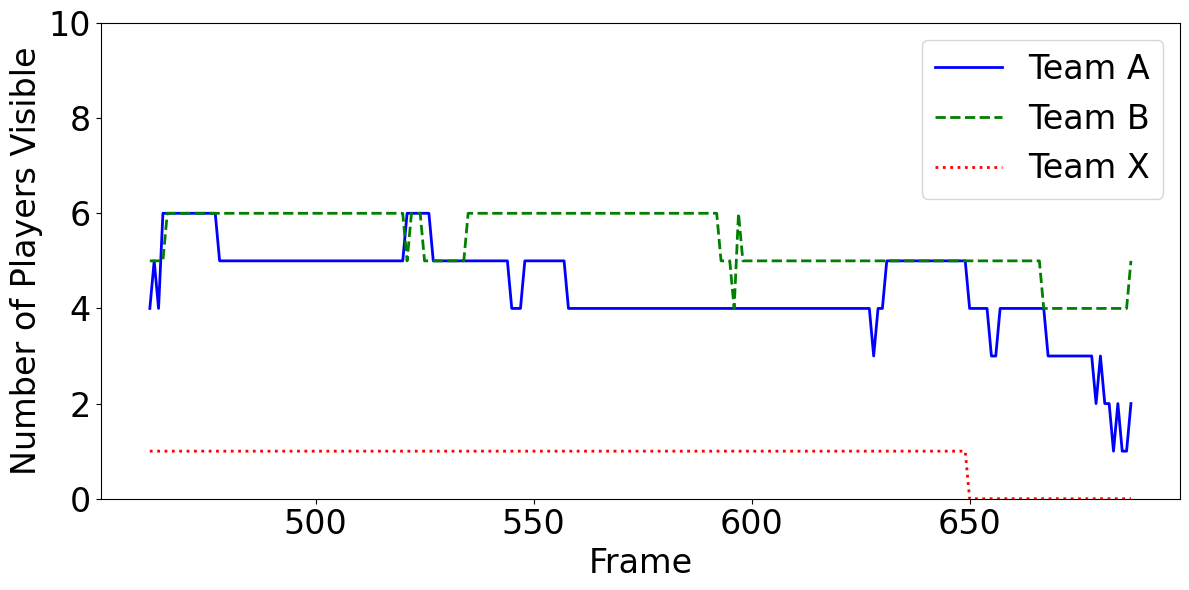

In [ ]:
# === 1. Load the data (CSV) ===
df = read_csv(f"{save_dir}/{mbc_active_dir}/data_tracking.csv", sep=";")

# === Colors for each team ===
color_map = {"A": "blue", "B": "green", "X": "red"}

# === Loop per session ===
for session_id, session_df in df.groupby("session_id"):
    print(f"Processing session {session_id}...")

    # === 1. Player Appearance Frequency (Accessible Version) ===
    appearance_counts = session_df.groupby("TrackID")["FrameID"].nunique()
    team_assignments = session_df.groupby("TrackID")["team_assignment"].first()

    # Team colors from color_map
    colors = [color_map.get(team_assignments[track_id], "gray") for track_id in appearance_counts.index]

    # Hatch patterns for accessibility
    hatch_map = {"A": "//", "B": "\\\\", "X": "xx"}
    hatches = [hatch_map.get(team_assignments[track_id], "xx") for track_id in appearance_counts.index]

    plt.figure(figsize=(10, 6))
    bars = appearance_counts.plot(kind="bar", color=colors)

    # Add hatch patterns to each bar
    for bar, hatch in zip(bars.patches, hatches):
        bar.set_hatch(hatch)

    # plt.title(f"Player Appearance Frequency (Session {session_id})", fontsize=20)
    plt.xlabel("TrackID (Player)", fontsize=20)
    plt.ylabel("Number of Frames Appeared", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(0,250)

    # === Legend with both color and hatch pattern ===
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color_map["A"], hatch=hatch_map["A"], label="Team A"),
        Patch(facecolor=color_map["B"], hatch=hatch_map["B"], label="Team B"),
        Patch(facecolor=color_map["X"], hatch=hatch_map["X"], label="Team X")
    ]
    plt.legend(handles=legend_elements, title="Team", fontsize=18, title_fontsize=18)

    plt.tight_layout()
    plt.show()
    plt.close()


    # === 2. Coarse Movement Patterns (Accessible Version - High Contrast) ===
    plt.figure(figsize=(10, 7))

    # Marker dan linestyle khusus per tim
    style_map = {
        "A": {"marker": "o", "linestyle": "-"},
        "B": {"marker": "s", "linestyle": "--"},
        "X": {"marker": "^", "linestyle": ":"}
    }

    for track_id, group in session_df.groupby("TrackID"):
        team = group["team_assignment"].iloc[0]
        color = color_map.get(team, "gray")
        style = style_map.get(team, {"marker": "o",  "linestyle": "-"})

        # Trajectory line
        plt.plot(
            group["center_x"], group["center_y"],
            marker=style["marker"], markersize=3.5,
            # fillstyle=style["fillstyle"],
            linestyle=style["linestyle"], linewidth=1,
            color=color,
            label=f"Player {track_id} ({team})"
        )

        # Label at the last point
        last_point = group.iloc[-1]
        plt.text(
            last_point["center_x"], last_point["center_y"],
            str(track_id),
            fontsize=14, fontweight="bold", color=color
        )

    # plt.title(f"Coarse Movement Patterns (Session {session_id})", fontsize=16)
    plt.xlabel("X Position", fontsize=20)
    plt.ylabel("Y Position", fontsize=20)
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(1100, 200)

    # Compact legend per team
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=color_map["A"], marker="o", linestyle="-", markersize=10, label="Team A"),
        Line2D([0], [0], color=color_map["B"], marker="s", linestyle="--", markersize=10, label="Team B"),
        Line2D([0], [0], color=color_map["X"], marker="^", linestyle=":", markersize=10, label="Team X")
    ]
    plt.legend(handles=legend_elements, title="Teams", fontsize=18, title_fontsize=18)

    plt.tight_layout()
    plt.show()
    plt.close()


    # === 3. Average Position per Player ===
    plt.figure(figsize=(10, 7))

    # Custom marker per team
    marker_map = {"A": "o", "B": "s", "X": "^"}

    for track_id, group in session_df.groupby("TrackID"):
        team = group["team_assignment"].iloc[0]
        color = color_map.get(team, "gray")
        marker = marker_map.get(team, "o")

        avg_x = group["center_x"].mean()
        avg_y = group["center_y"].mean()

        # Scatter plot for each player
        plt.scatter(avg_x, avg_y, color=color, marker=marker, s=180, alpha=0.8,
                    label=f"Player {track_id} ({team})")
        plt.text(avg_x + 5, avg_y, str(track_id), fontsize=14, fontweight="bold")

    plt.title(f"Average On-Screen Position of Players (Session {session_id})", fontsize=16)
    plt.xlabel("X Position", fontsize=20)
    plt.ylabel("Y Position", fontsize=20)
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Compact legend per team
    legend_elements = [
        Line2D([0], [0], marker="o", color="w", label="Team A",
              markerfacecolor=color_map["A"], markersize=12),
        Line2D([0], [0], marker="s", color="w", label="Team B",
              markerfacecolor=color_map["B"], markersize=12),
        Line2D([0], [0], marker="^", color="w", label="Team X",
              markerfacecolor=color_map["X"], markersize=12),
    ]
    plt.legend(handles=legend_elements, title="Teams", fontsize=20, title_fontsize=20)

    plt.tight_layout()
    plt.show()
    plt.close()


    # === 4. Team Visibility Over Time ===
    # Count unique players per team in each frame
    visibility = session_df.groupby(["FrameID", "team_assignment"])["TrackID"].nunique().unstack(fill_value=0)

    # Colors for each team (already defined)
    color_map = {"A": "blue", "B": "green", "X": "red"}

    # Style for each team (no markers, only different linestyles)
    style_map = {
        "A": {"linestyle": "-"},
        "B": {"linestyle": "--"},
        "X": {"linestyle": ":"},
    }

    plt.figure(figsize=(12, 6))
    for team in visibility.columns:
        plt.plot(
            visibility.index,
            visibility[team],
            label=f"Team {team}",
            color=color_map.get(team, "gray"),
            linestyle=style_map.get(team, {}).get("linestyle", "-"),
            linewidth=2
        )

    # plt.title(f"Team Visibility Over Time (Session {session_id})", fontsize=20)
    plt.xlabel("Frame", fontsize=24)
    plt.ylabel("Number of Players Visible", fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.ylim(0, 10)
    plt.tight_layout()
    plt.show()
    plt.close()
